## Goal
- Implement classification with resnet18 in tinyImagenet dataset using d2l library
    - Wrap tiny imagenet data under d2l library
    - Fit with GPU
    - Record validation losses, accuracy, time taken to train

In [1]:
import torch
import time
import d2l.torch as d2l
import torch.nn as nn
import numpy as np
from matplotlib import pyplot as plt
from torchvision.transforms import transforms
from torchvision.models import resnet18
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
from datasets import load_dataset, Image
import json
import requests
from data import TinyImagenetD2l

In [ ]:
batch_size = 256
num_workers = 2
learning_rate = 0.01
num_epochs = 100
device = d2l.try_gpu()
device

device(type='cuda', index=0)

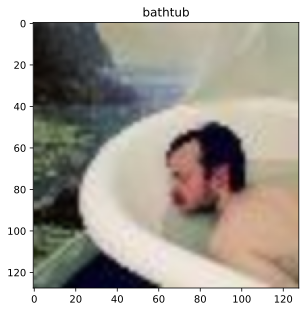

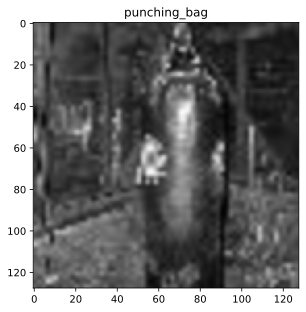

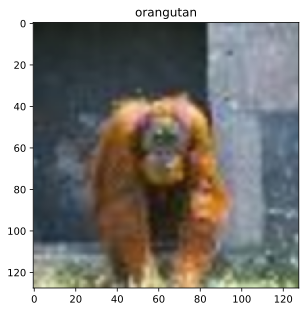

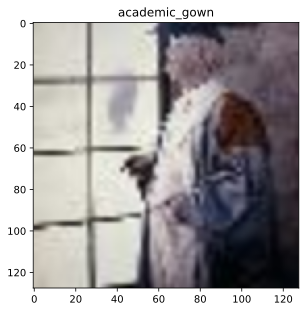

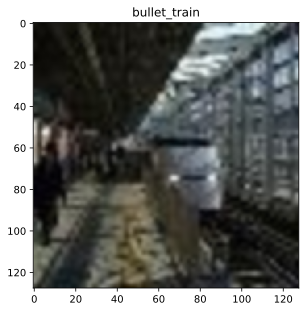

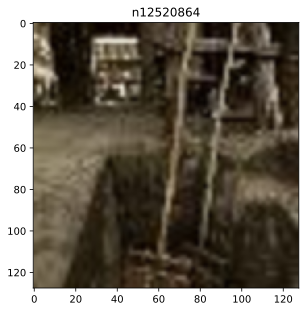

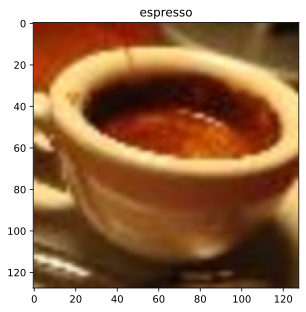

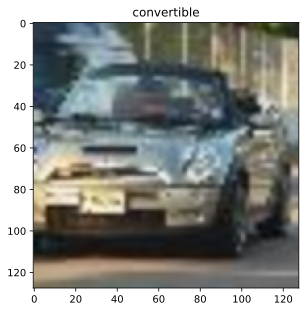

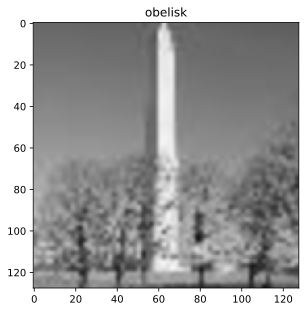

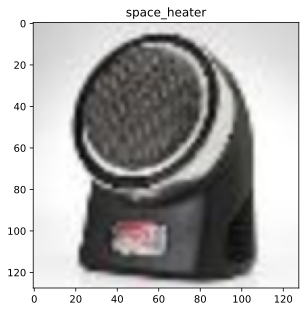

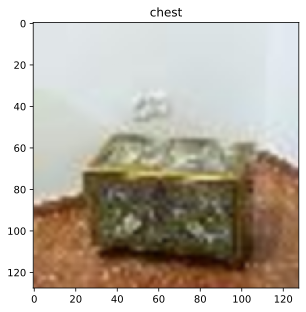

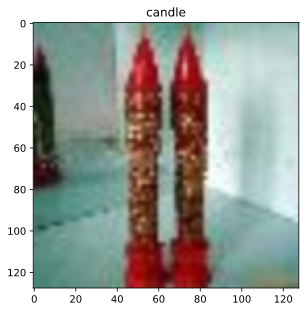

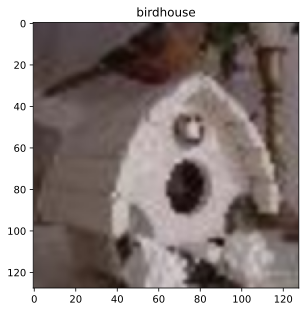

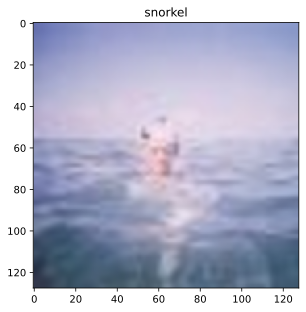

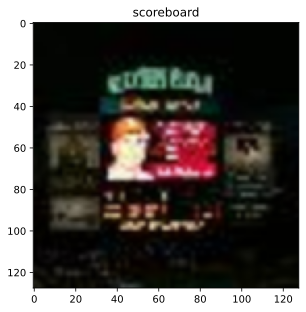

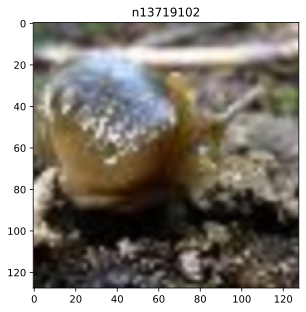

In [10]:
tiny_imagenet = TinyImagenetD2l(batch_size, num_workers, is_toy=False)
train_loader = tiny_imagenet.get_dataloader(train=True)
val_loader = tiny_imagenet.get_dataloader(train=False)

tiny_imagenet.visualize(next(iter(train_loader)))


In [ ]:
from models import ResnetCheckpointed
class ResnetD2l(d2l.Classifier):
    def __init__(self, num_classes, pretrained=False, lr=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.net = ResnetCheckpointed(pretrained=pretrained)
        self.net.fc = nn.Linear(512, num_classes)

        def init_weights(m):
            if type(m) == nn.Linear or type(m) == nn.Conv2d:
                nn.init.xavier_uniform_(m.weight)
        self.net.apply(init_weights)
    
    def forward(self, x):
        return self.net(x)
    
    def loss(self, y_hat, y):
        return nn.CrossEntropyLoss()(y_hat, y)

In [5]:
@d2l.add_to_class(d2l.Trainer)
def prepare_batch(self, batch):
    x = batch['image']
    y = batch['label']
    return (x.to(self.device), y.to(self.device))

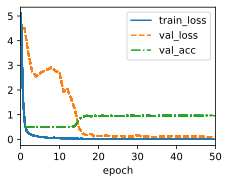

In [6]:
data = TinyImagenetD2l(batch_size, num_workers, is_toy=True)
model = ResnetD2l(num_classes=data.num_classes, pretrained=False, lr=learning_rate)
model.to(device)
trainer = d2l.Trainer(max_epochs=num_epochs, num_gpus=1)
trainer.device = device
trainer.fit(model=model, data=data)
